# Modelos de Riesgo de Crédito de Merton y KMV (Moody's)
---
El modelo de Merton (1974) trata la deuda de una empresa como una opción put y el equity como una opción call sobre los activos de la firma. El modelo de Merton hace parte de la familia de los modelos Estructurales (Merton / KMV).

El modelo de Merton (1974) establece que el **patrimonio (Equity) de una empresa es conceptualmente una opción de compra (call option) sobre los activos totales ($V_A$) de la empresa, con un precio de ejercicio (strike price) igual al valor nominal de su deuda ($D$)**.

**Condición de Default**: La empresa incumple si, al vencimiento de la deuda ($T$), el valor de sus activos es menor que el monto de la deuda ($V_A < D$).

**El Desafío**: El valor de mercado de los activos ($V_A$) y su volatilidad ($\sigma_V$) no son observables. Lo que sí observamos es el valor de mercado del patrimonio ($E_0$) (capitalización bursátil) y la volatilidad del patrimonio ($\sigma_E$) (volatilidad de la acción).

**La Solución del problema**: se debe resolver un sistema de dos ecuaciones no lineales para encontrar las dos incógnitas ($V_A$ y $\sigma_V$):

1. **Valor del Patrimonio**: Es la fórmula de Black-Scholes-Merton para una opción de compra.

$$E_0 = V_A N(d_1) - D e^{-rT} N(d_2)$$

2. Volatilidad?

Una vez que el sistema se resuelve iterativamente, obtenemos $V_A$ y $\sigma_V$. Con esto, calculamos la métrica principal:

* **Distancia al Default (DD)**: Es el número de desviaciones estándar que el valor esperado de los activos está por encima del punto de default (la deuda).

$$DD = \frac{\ln(V_A / D) + (\mu - 0.5 \sigma_V^2) T}{\sigma_V \sqrt{T}}$$
Donde $\mu$ es el retorno esperado de los activos.

* **Probabilidad de Default (DD)**: Es la probabilidad (asumiendo una distribución normal) de que los activos caigan por debajo de la barrera de la deuda. Es el término usado por KMV (Moody's).

$$PD = N(-DD)$$

**Este modelo tiene un fundamento: Modelos Black-Sholes para opciones Europeas**

Modelo Black-Scholes para Opciones Call Europeas
---
Para entender el modelo Merton-KMV de riesgo de crédito, primero debemos conocer el modelo **Black-Scholes para opciones Call europeas**, ya que Merton (1974) lo usa como base estructural para modelar el equity de una empresa como una opción.

El modelo de Black-Scholes (BS) fue la primera fórmula de forma cerrada que nos dio un precio teórico para valorar la incertidumbre.

**1 . ¿Qué es una Opción Call Europea?**

Una Opción Call Europea es un contrato que le da al comprador el derecho, pero no la obligación, de comprar un activo subyacente (como una acción, $S$) a un precio fijo (el Strike Price, $K$) en una fecha futura específica (la fecha de vencimiento, $T$).

Si en la fecha $T$, el precio de la acción ($S_T$) es mayor que el precio pactado ($K$), el comprador ejerce su derecho, compra la acción a $K$ y la puede vender inmediatamente a $S_T$, ganando la diferencia ($S_T - K$).

Si $S_T$ es menor que $K$, el comprador no ejerce el derecho (no compraría algo a $K$ que puede comprar más barato a $S_T$) y la opción expira sin valor.

Por lo tanto, el valor de la opción al vencimiento (Payoff) es:

$$Payoff = \max(S_T - K, 0)$$

El desafío que resolvieron Black, Scholes fue: ¿cuánto vale ese contrato hoy (en $t=0$)?

**2 . La Intuición del Modelo**

El precio de la opción call hoy ($C$) debe ser el valor presente del payoff esperado en el futuro. El modelo BS nos dice que el precio de la opción es una combinación de dos partes:

$$C = (\text{Lo que esperamos recibir}) - (\text{Lo que esperamos pagar})$#

* Lo que esperamos recibir: El valor presente de la acción ($S_0$), ponderado por la probabilidad de que terminemos ejerciéndola (recibiendo la acción).
* Lo que esperamos pagar: El valor presente del strike price ($K e^{-rT}$), ponderado por la probabilidad de que tengamos que pagarlo (es decir, que la opción se ejerza).

**3 . El Modelo Formal (La Fórmula BSM)**
La fórmula de Black-Scholes para el precio de una Opción Call Europea ($C$) es:

$$C = S_0 N(d_1) - K e^{-rT} N(d_2)$$
Donde los 5 inputs clave son:
* $S_0$ = Precio actual del activo subyacente (ej. precio de la acción hoy).
* $K$ = Precio de ejercicio (Strike Price).
* $T$ = Tiempo hasta el vencimiento (en años).
* $r$ = Tasa de interés libre de riesgo (continua y anualizada).
* $\sigma$ = Volatilidad (desviación estándar) de los retornos del activo subyacente.

Y los componentes de la fórmula son:
* $N(\cdot)$ = Función de distribución normal acumulada estándar (es decir, "la probabilidad de que un valor sea menor que...").
* $d_1 = \frac{\ln(S_0 / K) + (r + 0.5 \sigma^2) T}{\sigma \sqrt{T}}$
* $d_2 = d_1 - \sigma \sqrt{T}$

**4 . Interpretación de la Fórmula**

Aquí es donde reside la elegancia del modelo:
* $K e^{-rT}$: Es simplemente el valor presente (descontado a tasa libre de riesgo $r$) del dinero ($K$) que tendríamos que pagar en el futuro $T$.
* $N(d_2)$: Esta es la parte crucial. $N(d_2)$ representa la probabilidad (en un mundo "riesgo-neutral") de que la opción se ejerza. Es la probabilidad de que $S_T > K$.
* $K e^{-rT} N(d_2)$: Multiplicados, son el valor presente del costo esperado de ejercer la opción.
* $S_0 N(d_1)$: Este término representa el valor presente del beneficio esperado de recibir la acción (si se ejerce la opción).
* $N(d_1)$ actúa como un factor de probabilidad ajustado por el valor del activo.

In [2]:
import yfinance as yf, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Black-Scholes Call
def black_scholes_call(S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

In [4]:
# Ejemplo: Empresa X
S0 = 100      # Precio hoy de la acción (USD)
sigma = 0.30   # 30%
K = 120       # Strike
r = 0.05       # 5%
T = 1.0        # 1 año

#print(f'Precio de la opicón Call: ${result:.2f}')

In [5]:
# Podemos rescatar codigos anterioes para traer informacion de compañias
# start = '2020-10-01'
# end = '2025-10-31'
# precios = yf.download("AAPL", start=start, end = end)['Close']
# retornos = np.log(precios/precios.shift()).dropna()

In [6]:
#black_scholes_call(S0, K, r, sigma, T)

Del Black-Scholes al Modelo Merton (1974)
---
Idea estructural: "**La empresa como una opción**"

*"El equity de una empresa apalancada es una opción Call sobre sus activos"*



In [7]:
# Analogía Black-Scholes → Merton
data = {
    "Concepto": ["Activo subyacente (S₀)", "Strike (K)", "Precio de la Call (C)", "Vencimiento (T)" ],
    "Analogía con Black-Scholes": [ "Valor de los activos de la empresa (V)","Valor nominal de la deuda (D)",
        "Valor de mercado del equity (E₀)", "Horizonte de la deuda (ej. 1 año)" ]
}
df_analogia = pd.DataFrame(data)
print("Analogía entre Black-Scholes y Modelo Merton\n")
display(df_analogia)

Analogía entre Black-Scholes y Modelo Merton



,Concepto,Analogía con Black-Scholes
0,Activo subyacente (S₀),Valor de los activos de la empresa (V)
1,Strike (K),Valor nominal de la deuda (D)
2,Precio de la Call (C),Valor de mercado del equity (E₀)
3,Vencimiento (T),Horizonte de la deuda (ej. 1 año)


---------------------------------------------------------------------------------------------

**Ahora sí, a lo que vamos**!!

Paso 1: Definir Parámetros Iniciales
---
Fundamento: Definimos las variables exógenas de nuestro modelo:

* Ticker: La empresa que vamos a analizar (AAPL).
* Tasa Libre de Riesgo ($r$): El retorno de un activo sin riesgo para el horizonte de tiempo. Usaremos un 3.7% (0.037) como aproximación de la tasa del Tesoro de EE. UU. a 1 año.
* Horizonte de Tiempo ($T$): El período para el calculo de la probabilidad de default. El estándar de la industria es 1 año ($T=1$).

In [8]:
# Parámetros Iniciales
ticker = 'AAPL' # Ticket de la compañía o empresa
r = 0.037       # Tasa libre de riesgo (US 1Y Treasury ~3.7%) / ajustar segun el mercado
T = 1.0         # Horizonte de tiempo (1 año) - la estimación es anual

print(f"Empresa")
print(f"  Ticker: {ticker}")
print(f"  Tasa libre de riesgo (r): {r:.2%}")
print(f"  Horizonte (T): {T} año")

Empresa
  Ticker: AAPL
  Tasa libre de riesgo (r): 3.70%
  Horizonte (T): 1.0 año


Paso 2: Obtener Datos Observables del Patrimonio ($E_0$ y $\sigma_E$)
---
El modelo KMV se basa en lo que podemos observar en el mercado para estimar lo que no podemos. Los primeros dos observables clave provienen del mercado de acciones:

* Valor del Patrimonio ($E_0$): Es la capitalización de mercado (Market Cap) de la empresa. Es el valor actual de todas sus acciones.
* Volatilidad del Patrimonio ($\sigma_E$): Es la volatilidad (desviación estándar) de los retornos de la acción. La calculamos como la desviación estándar anualizada de los retornos logarítmicos diarios del último año (252 días de trading)

In [9]:
# Crear el objeto Ticker
ticker_obj = yf.Ticker(ticker)
# 1. Obtener E0 (Valor de Mercado del Patrimonio)
E0 = ticker_obj.info['marketCap']
print(f" Valor del Patrimonio ($E_0$): {E0:,.0f}")

# 2. Obtener sigma_E (Volatilidad del Patrimonio)
hist = ticker_obj.history(period="1y")
hist['log_return'] = np.log(hist['Close'] / hist['Close'].shift(1))
# Calcular volatilidad anualizada
sigma_E = hist['log_return'].std() * np.sqrt(252)
print(f" Volatilidad del Patrimonio ($\\sigma_E$): {sigma_E:.2%}")

 Valor del Patrimonio ($E_0$): 3,967,007,326,208
 Volatilidad del Patrimonio ($\sigma_E$): 32.35%


In [10]:
# Función para obtener market cap y volatilidad de equity
# def get_market_data(ticker, period='1y'):
#     stock = yf.Ticker(ticker)
#     hist = stock.history(period=period)
#     closes = hist['Close'].dropna()
#     returns = np.log(closes / closes.shift(1)).dropna()
#     sigma_E = np.std(returns) * np.sqrt(252)                # Vol anualizada
#     market_cap = stock.info.get('marketCap', np.nan) / 1e6  # En millones
#     shares = stock.info.get('sharesOutstanding', np.nan)
#     return market_cap, sigma_E, shares

Paso 3: Obtener Datos Observables de la Deuda ($D$)
---
Necesitamos el tercer observable: la Barrera de Default ($D$). Este es el valor de los pasivos que, de no poder cubrirse con los activos, llevaría a la quiebra.

El modelo KMV utiliza una definición específica: $D = \text{Deuda a Corto Plazo} + 0.5 \times \text{Deuda a Largo Plazo}$

Usamos esta fórmula porque la deuda a corto plazo es una obligación inmediata (vence este año), mientras que solo una porción de la deuda a largo plazo es relevante para el riesgo del próximo año.

In [11]:
def get_value(balance_sheet, keys: list, default=0):
    """Función para obtener información del balance sheet."""
    for key in keys:
        if key in balance_sheet.index:
            value = balance_sheet.loc[key]
            if value is not None and not np.isnan(value):
                return float(value)
    return default

bs = ticker_obj.balance_sheet

if bs.empty:
    print(f"Error: No se pudo obtener balance para {ticker}.")
    D = None
else:
    # Obtener la columna más reciente
    latest_bs = bs[bs.columns[0]]

    # Claves posibles para Deuda a Corto Plazo
    std_keys = ['Short Long Term Debt', 'Short Term Debt', 'Current Debt']
    # Claves posibles para Deuda a Largo Plazo
    ltd_keys = ['Long Term Debt']

    std = get_value(latest_bs, std_keys, 0)
    ltd = get_value(latest_bs, ltd_keys, 0)

    print(f"  Deuda Corto Plazo (STD): {std:,.0f}")
    print(f"  Deuda Largo Plazo (LTD): {ltd:,.0f}")

    # Calcular la barrera de default (DP)
    D = std + 0.5 * ltd

    # Manejar el caso de empresas sin deuda
    if D <= 0:
        print(" La empresa no tiene deuda significativa o no tiene información disponible.")
        D = 1e-9 # Usamos un valor piso muy pequeño para evitar errores en logaritmos

    print(f"  Barrera de Default ($DP$) [STD + 0.5*LTD]: {D:,.0f}")

  Deuda Corto Plazo (STD): 20,879,000,000
  Deuda Largo Plazo (LTD): 85,750,000,000
  Barrera de Default ($DP$) [STD + 0.5*LTD]: 63,754,000,000


In [12]:
# # Función para estimar deuda
# def estimate_debt(ticker):
#     stock = yf.Ticker(ticker)
#     balance = stock.balance_sheet
#     if not balance.empty:
#         total_debt = balance.loc['Total Debt'].iloc[0] / 1e6 if 'Total Debt' in balance.index else np.nan
#         short_term_debt = balance.loc['Short Long Term Debt'].iloc[0] / 1e6 if 'Short Long Term Debt' in balance.index else 0
#         long_term_debt = total_debt - short_term_debt
#         DP = short_term_debt + 0.5 * long_term_debt
#     else:
#         DP = np.nan
#     return DP

Paso 4: Definir el Sistema de Ecuaciones
---
Aquí está el núcleo del modelo de Merton.

Tenemos 2 observables ($E_0$, $\sigma_E$) y 2 incógnitas ($V_A$, $\sigma_V$).

Para resolverlo, necesitamos 2 ecuaciones que las relacionen.

* Ecuación 1: El Valor del Patrimonio ($E_0$)

Merton (1974) demostró que el patrimonio de una empresa es una opción de compra (call option) sobre los activos totales de la empresa ($V_A$), con un precio de ejercicio (strike) igual a la barrera de default ($D$).La fórmula es la de Black-Scholes-Merton:

$$E_0 = V_A N(d_1) - D e^{-rT} N(d_2)$$

* Ecuación 2: La Volatilidad del Patrimonio ($\sigma_E$)
Merton demostró que se puede derivar una relación entre la volatilidad del patrimonio ($\sigma_E$) y la volatilidad de los activos ($\sigma_V$):

$$\sigma_E = \left( \frac{V_A}{E_0} \right) N(d_1) \sigma_V$$

Donde $d_1$ y $d_2$ son los términos estándar de Black-Scholes:

$$d_1 = \frac{\ln(V_A / D) + (r + 0.5 \sigma_V^2) T}{\sigma_V \sqrt{T}}$$
$$d_2 = d_1 - \sigma_V \sqrt{T}$$

Definimos una función de Python que toma las incógnitas ($VA$, $\sigma_V$) y devuelve el error de ambas ecuaciones. El solver fsolve intentará llevar estos errores a cero.

In [13]:
def system_of_equations(vars, E0, D, sigma_E, r, T):
    """
    Define el sistema de dos ecuaciones no lineales que el solver debe resolver.
    Args:
        vars (list): [VA, sigma_V], las dos incógnitas.
        E0, D, sigma_E, r, T (float): Los parámetros conocidos.
    Returns:
        list: [eq1_error, eq2_error], los errores que fsolve minimizará a cero.
    """
    VA, sigma_V = vars[0], vars[1]

    # Restricción: V_A y sigma_V deben ser positivos
    if VA <= 0 or sigma_V <= 0.0001:
        return [1e6, 1e6]  # Retorna un error grande
    # Calcular d1 y d2
    d1 = (np.log(VA / D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)

    # Ecuación 1: E0 = BSM_Call(VA, D, r, T, sigma_V)
    eq1 = E0 - (VA * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2))

    # Ecuación 2: sigma_E = (VA / E0) * N(d1) * sigma_V
    eq2 = sigma_E - (VA / E0) * norm.cdf(d1) * sigma_V
    return [eq1, eq2]

In [14]:
# def merton_kmv_solver(params):
#     E0, sigma_E, D, r, T = params
#     def equations(x):
#         V, sigma_V = x
#         d1 = (np.log(V / D) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
#         d2 = d1 - sigma_V * np.sqrt(T)
#         eq1 = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2) - E0
#         eq2 = (V / E0) * norm.cdf(d1) * sigma_V - sigma_E
#         return [eq1, eq2]
#     # Inicialización
#     V_init = E0 + D
#     sigma_V_init = sigma_E * (E0 / V_init)
#     solution = fsolve(equations, [V_init, sigma_V_init])
#     return solution[0], solution[1]

# pr = [E0, sigma_E, D, r, T]
# merton_kmv_solver(pr)

Paso 5: Resolver el Modelo para $V_A$ y $\sigma_V$
---
Fundamento y Metodología: No podemos despejar $V_A$ y $\sigma_V$ algebraicamente. Usamos un solver numérico (fsolve) para encontrar las raíces de nuestra función system_of_equations.

El solver necesita una "estimación inicial" (un punto de partida). Una conjetura lógica y estándar es:

* $V_A$ (inicial) $\approx E_0 + D$ (El valor de los activos es aprox. patrimonio + deuda)
* $\sigma_V$ (inicial) $\approx \sigma_E \times (\frac{E_0}{E_0 + D})$ (La volatilidad de los activos es una fracción de la volatilidad del patrimonio.

In [15]:
# Solo procedemos si tenemos todos los inputs
if E0 and sigma_E and D:
    # Estimación inicial (guess) para el solver
    initial_guess = [E0 + D, sigma_E * (E0 / (E0 + D))]

    print(f"  Estimación inicial $V_A$: {initial_guess[0]:,.0f}")
    print(f"  Estimación inicial $\\sigma_V$: {initial_guess[1]:.2%}")

    # Usar fsolve para encontrar las raíces [VA, sigma_V]
    try:
        solution = fsolve(
            system_of_equations,
            initial_guess,
            args=(E0, D, sigma_E, r, T),
            xtol=1e-6 # Tolerancia
        )

        VA_est = solution[0]
        sigma_V_est = solution[1]

        if VA_est < 0 or sigma_V_est < 0:
            raise Exception("Solver convergió a una solución no válida (negativa).")

        print(f"  Valor Estimado de Activos ($V_A$): {VA_est:,.0f}")
        print(f"  Volatilidad Estimada de Activos ($\\sigma_V$): {sigma_V_est:.2%}")

    except Exception as e:
        print(f"Error: El solver falló. {e}")
        VA_est, sigma_V_est = None, None
else:
    print("Faltan datos (E0, sigma_E, o D) para ejecutar el solver.")
    VA_est, sigma_V_est = None, None

  Estimación inicial $V_A$: 4,030,761,326,208
  Estimación inicial $\sigma_V$: 31.84%
  Valor Estimado de Activos ($V_A$): 4,028,445,534,541
  Volatilidad Estimada de Activos ($\sigma_V$): 31.86%


Paso 6: Calcular las Métricas Finales de Riesgo (DD y PD)
---
Ahora que hemos estimado los valores "no observables" ($V_A$ y $\sigma_V$), podemos calcular las métricas de riesgo reales.

1. Distancia al Default (DD):Esta es la métrica más importante. Mide cuántas desviaciones estándar ($\sigma_V$) está el valor esperado de los activos ($V_A$) por encima de la barrera de default ($D$) al final del período $T$.

$$DD = \frac{\ln(V_A / D) + (\mu - 0.5 \sigma_V^2) T}{\sigma_V \sqrt{T}}$$

**Nota**: Usamos $\mu = r$ como deriva, que es una simplificación estándar que equipara el DD a $d_2$ del mundo real.

2. Probabilidad de Default (PD / EDF): Asumiendo que los retornos de los activos siguen una distribución normal, la probabilidad de que $V_A$ caiga por debajo de $D$ es $N(-DD)$.

3. Fórmula: $PD = N(-DD)$

4. Spread de Crédito. Podemos usar los mismos parámetros para calcular el spread teórico que el mercado debería exigirle a la deuda de esta empresa sobre la tasa libre de riesgo. Fórmula:

$$\text{Spread} = -\frac{1}{T} \ln\left(\frac{V_A - E_0}{D}\right) - r$$

In [16]:
if VA_est and sigma_V_est and D > 1e-9:
    # 1. Distancia al Default (DD)
    #    Usamos mu=r para la deriva, lo que hace DD = d2 (real)
    DD = (np.log(VA_est / D) + (r - 0.5 * sigma_V_est**2) * T) / (sigma_V_est * np.sqrt(T))

    # 2. Probabilidad de Default (PD) - Mundo Real
    PD_real = norm.cdf(-DD)

    # 3. Spread de Crédito (Teórico)
    # Primero calculamos el valor de la deuda B0 = VA - E0
    B0 = VA_est - E0
    # Spread = - (1/T) * ln(B0 / D) - r
    credit_spread = -(1/T) * np.log(B0 / D) - r

    print(f"  RESULTADOS PARA: {ticker}")
    print(f"  Distancia al Default (DD): {DD:.4f}")
    print(f"  Probabilidad de Default (Teórico): {PD_real:.6%}")
    print(f"  Spread de Crédito (Teórico): {credit_spread*10000:.2f} bps")
    print("\n ------------------------------------------------------------")

elif D <= 1e-9:
    print(f"  RESULTADOS PARA: {ticker}")
    print(f"  Empresa sin deuda. PD se asume como 0.")
    print(f"  Distancia al Default (DD): Infinito")
    print(f"  Probabilidad de Default (Teórico): 0.000000%")
    print("\n --------------------------------------------------")

else:
    print("No se pudieron calcular las métricas finales debido a un error previo.")

  RESULTADOS PARA: AAPL
  Distancia al Default (DD): 12.9721
  Probabilidad de Default (Teórico): 0.000000%
  Spread de Crédito (Teórico): 0.00 bps

 ------------------------------------------------------------


In [17]:
# def calculate_metrics(V, sigma_V, DP, r, T):   #mu = r   # Risk-Neutral measure
#     d1 = (np.log(V / DP) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
#     d2 = d1 - sigma_V * np.sqrt(T)
#     PD_merton = norm.cdf(-d2)  # Neutral
#     DD = (np.log(V / DP) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
#     EDF_kmv = norm.cdf(-DD)
#     B0 = V - (V * norm.cdf(d1) - DP * np.exp(-r * T) * norm.cdf(d2))
#     spread = - (1/T) * np.log(B0 / DP) - r if B0 > 0 else np.nan
#     return PD_merton, DD, spread

 **Revisión del proceso**:

 Hemos construido el modelo desde cero. Obtuvimos los datos observables ($E_0, \sigma_E, D$), definimos el sistema de ecuaciones de Merton y lo resolvimos numéricamente para encontrar los datos no observables ($V_A, \sigma_V$). Finalmente, usamos estos valores estimados para calcular la Distancia al Default y la Probabilidad de Default, que son las métricas clave para nuestra gestión de riesgos.

Deber: Aplicación para algunas compañías de LA
---
Se debe generar una lista de compañías que se cotizan en bolsas de valores de los mercados de LA.

In [18]:
# Escoger 4 empresas de cada país
BRASIL = ['CMIG4.SA','CPLE6.SA','ELET3.SA','BBDC3.SA','BBAS3.SA','CYRE3.SA','BRAP4.SA','CPFE3.SA']
CHILE  = ['VAPORES.SN','HABITAT.SN','CENCOSUD.SN','CHILE.SN','COLBUN.SN','SQM-B.SN','CAP.SN']
MEXICO = ['AMXB.MX','GCARSOA1.MX','WALMEX.MX','GMEXICOB.MX','CEMEXCPO.MX','LABB.MX','OMAB.MX']
COLOMBIA = ['NUTRESA.CL',  'CELSIA.CL', 'ISA.CL', 'ECOPETROL.CL', 'PFDAVVNDA.CL', 'BOGOTA.CL', 'PFCIBEST.CL']

In [19]:
# Tasas libres de riesgo para mercados de LA
# BRASIL: ~15% -World Government Bonds (a nov 2025)
# CHILE: ~5% - CEIC Data (marzo 2025)
# MEXICO: ~9% - Trading Economics (aprox. CETES 1Y)
# COLOMBIA: ~ 10% - Cbonds - Alto por inflación

Y si lo vamos a aplicar en Ecuador?
---

In [20]:
# ECUADOR:
# Tasa rf~6% (yield de bonos soberanos locales 1y + prima emergente; fuente: BCE y Cbonds, nov 2025).

# Si seleccionamos algunas empresas representativas (top por market cap y liquidez):

# Corporación Favorita C.A. (Ticker: SLU, BVG): Retail (supermercados). Market cap: 1.443B USD. Deuda total ~500M USD (short: 100M, long: 400M → DP=300M). σ_E=25%.
# Banco Guayaquil S.A. (Ticker: GYL, BVG): Banca. Market cap: 1.79B USD. Pasivos ~7.85B USD (short: 2B, long: 5B → DP=4.5B). σ_E=28%.
# Holcim Ecuador S.A. (Ticker: HLE, BVQ): Cemento. Market cap: 1.07B USD. Deuda total ~500M USD (short: 100M, long: 400M → DP=300M). σ_E=30%.
# Ingenio San Carlos S.A. (Ticker: SC, BVQ): Azucarero/manufactura. Alto apalancamiento (deuda/equity ~1.5; ventas volátiles por commodities). Market cap: 150M USD. DP: 300M (short 100M, long 200M). σ_E=35% (alta por precios azúcar).
# Hotel Colón S.A. (Ticker: HC, BVQ): Hotelería. Alto riesgo post-COVID (deuda/equity ~2.0; recuperación lenta). Market cap: 80M USD. DP: 200M (short 80M, long 120M). σ_E=40% (volátil por turismo).
# La Fabril S.A. (Ticker: LF, BVG): Alimentos (emisiones frecuentes, pero alto endeudamiento para expansión). Market cap: 200M USD. DP: 400M (short 150M, long 250M). σ_E=28%.

# Fuentes: PitchBook (market cap/shares), EMIS/D&B (deuda/revenue 2024-2025), BCE (tasas). Datos nov 2025; aproximaciones conservadoras para deuda/vol.

In [21]:
# Funciones
def equations(x, E0, sigma_E, DP, r, T):
    V, sigma_V = x
    if DP <= 0: return [0, 0]
    d1 = (np.log(V / DP) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    eq1 = V * norm.cdf(d1) - DP * np.exp(-r * T) * norm.cdf(d2) - E0
    eq2 = (V / E0) * norm.cdf(d1) * sigma_V - sigma_E
    return [eq1, eq2]

# Métricas
def calculate_metrics(V, sigma_V, DP, r, T):
    if DP <= 0 or not np.isfinite(V): return 0, 0, np.inf, 0
    d1 = (np.log(V / DP) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    DD = (np.log(V / DP) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    PD = norm.cdf(-DD)
    B0 = V - (V * norm.cdf(d1) - DP * np.exp(-r * T) * norm.cdf(d2))
    spread = -(1/T) * np.log(B0 / DP) - r if B0 > 0 else 0
    return norm.cdf(-d2), PD, DD, spread  # PD_Merton, PD_KMV, DD, Spread

# Parámetros comunes
r, T = 0.06, 1.0

# Empresas (hardcoded)
empresas = {
    'Corporacion Favorita': {'E0': 1443, 'sigma_E': 0.25, 'DP': 300},
    'Banco Guayaquil': {'E0': 1793, 'sigma_E': 0.28, 'DP': 4500},
    'Holcim Ecuador': {'E0': 1070, 'sigma_E': 0.30, 'DP': 300},
    'Ingenio San Carlos': {'E0': 150, 'sigma_E': 0.35, 'DP': 300},   # Alto apalancamiento
    'Hotel Colon': {'E0': 80, 'sigma_E': 0.40, 'DP': 200},           # Muy volátil
    'La Fabril': {'E0': 200, 'sigma_E': 0.28, 'DP': 400}             # Endeudamiento expansión
}

resultados = {}
for nombre, params in empresas.items():
    E0, sigma_E, DP = params.values()
    V_init = E0 + DP
    sigma_V_init = sigma_E * (E0 / V_init)
    V, sigma_V = fsolve(equations, [V_init, sigma_V_init], args=(E0, sigma_E, DP, r, T))
    _, PD, DD, spread = calculate_metrics(V, sigma_V, DP, r, T)
    resultados[nombre] = {'V (M USD)': round(V), 'σ_V': f"{sigma_V:.2%}", 'DD': round(DD, 2), 'PD (%)': f"{PD:.6%}", 'Spread (%)': f"{spread:.2%}"}

import pandas as pd
df = pd.DataFrame(resultados).T
print(df)

                     V (M USD)     σ_V    DD     PD (%) Spread (%)
Corporacion Favorita      1726  20.91%  8.55  0.000000%      0.00%
Banco Guayaquil           6031   8.32%   4.2  0.001354%      0.00%
Holcim Ecuador            1353  23.73%  6.48  0.000000%      0.00%
Ingenio San Carlos         433  12.14%  3.45  0.028323%      0.00%
Hotel Colon                268  11.94%   2.9  0.183838%      0.01%
La Fabril                  577   9.71%  4.34  0.000722%      0.00%


In [22]:
## -------------------------------------------------------------------------------
## -------------------------------------------------------------------------------

-------------------------------------------------------------------------------

## Caso de estudio - Startup de Ciberseguridad (Kronos)

**Pasos del proceso**:

* Recopilar inputs (funding, financieros).
* Estimar V y σ_V
* Calcular DD y PD
* Interpretar (rating, implicaciones para inversores).

**(Caso real adaptado)**

Kronos es una empresa de software diseñada para analizar, clasificar y encriptar documentos mediante algoritmos avanzados de IA, permitiendo a los clientes corporativos mitigar riesgos ciberseguridad.

**Escenario propuesto**: Evaluar riesgo para ronda Serie B a tres años.

**Datos de la empresa a 2025**:

* Funding: \$5M Serie A (2025, BuenTrip Ventures), post-money $22M.
* Deuda: \$3M (vencimiento 3 años, cupón 10%). ~Deuda total (no hay LTD).
* Ingresos: \$2M anuales, margen operativo 8%.
* Beta: 1.8 (riesgo sistemático vs. MSCI LatAm).
* Tasa libre de riesgo (r): 6% (BCE 2025).
* Prima de riesgo mercado (PRm): 8% (LatAm promedio, BCP).

* Tax: 25%
* Valor de mercado equity: \$22M - \$3M = \$19M.
* $μ_{equity}$ = r + beta * PRm = 6% + 1.8 * 8% = 20.4%
* $μ_{activos}$ = 20.4% * (\$19M / \$22M) + 10% * (\$3M / \$22M) * (1-25%) = 18.64%.
* $σ_{equity}$ = 45% (~ startups LatAm ciberseguridad, LAVCA 2025 (https://www.lavca.org/)).



## Implementación

**Alternativa 1: Usando Merton y KMV**

Esto requiere la estimación de $V_A$ y $σ_V$.

In [23]:
# Parámetros
E0 = 19                  # Market cap (equity) - 19 M
DP = 3                   # Default Point = Deuda total - 1 M
sigma_E = 0.45           # Volatilidad del equity
r = 0.06                 # Tasa libre de riesgo 1y (Ecuador 2025)
T = 3                    # Horizonte: 3 años

V_init = E0 + DP
sigma_V_init = sigma_E * (E0 / V_init)

print(f"Estimación inicial:")
print(f"  V_A^(0)  = {V_init:,.0f}")
print(f"  σ_V^(0)  = {sigma_V_init:.2%}\n")

Estimación inicial:
  V_A^(0)  = 22
  σ_V^(0)  = 38.86%



In [24]:
# Calculos de V_A y Sigma_V
V_A, sigma_V = fsolve(equations, [V_init, sigma_V_init], args=(E0, sigma_E, DP, r, T))
print(f"  V_A  = ${V_A:,.0f}")
print(f"  σ_V  = {sigma_V:.2%}\n")

  V_A  = $22
  σ_V  = 39.77%



**Cálculo de DD, Mapeo a PD y Rating**


In [44]:
d1 = (np.log(V_A / DP) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
d2 = d1 - sigma_V * np.sqrt(T)

DD = (np.log(V_A / DP) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
PD = norm.cdf(-DD)                 # PD teórica

print(f"RESULTADOS:")
print(f"  Distancia al Default (DD) = {DD:.2f}")
print(f"  Probabilidad de Default (PD) = {PD:.4%}")

RESULTADOS:
  Distancia al Default (DD) = 2.78
  Probabilidad de Default (PD) = 0.2749%


**Altrnativa 2: usando simulación de MC:**

La simulación de Movimiento Browniano Geométrico (MGB) con pasos anuales a 3 años:

Modelo: $  V_{t+1} = V_t \cdot e^{(r - \frac{1}{2}\sigma_V^2) + \sigma_V \cdot Z}  $, $  Z \sim N(0,1)  $

In [39]:
mu_E = 0.204
mu_V = r # 0.186
n_sim = 10000

In [40]:
# Monte Carlo para V
# Matriz: [n_sim, T_horizon + 1] → incluye V0
V0 = V_A
V_paths = np.zeros((n_sim, T+ 1))
V_paths[:, 0] = V0

# Simular trayectoria anual
for t in range(1, T + 1):
    Z = np.random.normal(0, 1, n_sim)  # Incremento normal
    drift = (mu_V - 0.5 * sigma_V_init**2) * 1  # Paso de 1 año
    diffusion = sigma_V_init * Z
    V_paths[:, t] = V_paths[:, t-1] * np.exp(drift + diffusion)

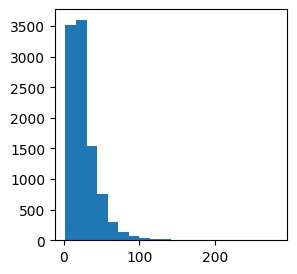

In [42]:
plt.figure(figsize=(3,3))
plt.hist(V_paths[:,3],bins=20);

In [49]:
# CALCULO DE DD Y PD POR AÑO
DD_annual = np.zeros(T)
PD_annual = np.zeros(T)

# MC
for t in range(1, T + 1):
    V_mean_t = np.mean(V_paths[:, t])
    sigma_V_t = np.std(np.log(V_paths[:, t] / V_paths[:, t-1]))

    # DD en año t
    DD = (np.log(V_mean_t / DP) + (mu_V - 0.5 * sigma_V_t**2) * t) / (sigma_V_t * np.sqrt(t))
    PD = norm.cdf(-DD)

    DD_annual[t-1] = DD
    PD_annual[t-1] = PD


In [50]:
# RESULTADOS
years = np.arange(1, T + 1)
results = pd.DataFrame({
    'Año': years,
    'V_promedio (M USD)': [np.mean(V_paths[:, t]) for t in years],
    'σ_V implícita': [np.std(np.log(V_paths[:, t]/V_paths[:, t-1])) for t in years],
    'DD': DD_annual,
    'PD (%)': [p*100 for p in PD_annual]
})

print("RESULTADOS MGB - PASOS ANUALES (3 años)")
display(results.round(4))

RESULTADOS MGB - PASOS ANUALES (3 años)


,Año,V_promedio (M USD),σ_V implícita,DD,PD (%)
0,1,22.8429,0.3881,5.1913,0.0000
1,2,24.3448,0.3870,3.7717,0.0081
2,3,25.9172,0.3821,3.1996,0.0688


### Mapeo del rating usando tabla Moody's KMV (2025)

In [45]:
if DD >= 6: rating = "AAA"
elif DD >= 4: rating = "AA"
elif DD >= 3: rating = "A"
elif DD >= 2: rating = "BBB"
elif DD >= 1: rating = "BB"
else: rating = "B o menor"

print(f"RESULTADOS:")
print(f"  Distancia al Default (DD) = {DD:.2f}")
print(f"  Probabilidad de Default (PD) = {PD:.4%}")
print(f"  Rating implícito (Moody's) ≈ {rating}")

RESULTADOS:
  Distancia al Default (DD) = 2.78
  Probabilidad de Default (PD) = 0.2749%
  Rating implícito (Moody's) ≈ BBB
